# Predict movie categories

In [1]:
from fastai.text import *
import pandas as pd
tok = Tokenizer(lang="en")
bs=24


In [6]:
query = """
SELECT movie_name, category_0
FROM tmp.evic_movies
"""

movies = pd.read_gbq(query, project_id="kwik-e-mart27")

In [8]:
movies.to_csv("data/movie_titles.csv")

In [9]:
sample = "movie_titles.csv" 
data_lm = TextLMDataBunch.from_csv('data/', sample, tokenizer=tok,
                                   text_cols=['movie_name'],
                                   bs=bs, valid_pct=0.1,
                                 label_cols="category_0")

data_lm.show_batch(rows=3)

idx,text
0,"beowulf & xxmaj xxunk ( 2005 ) xxbos xxmaj machine xxmaj girl , xxmaj the ( xxmaj xxunk xxunk xxunk ) ( 2008 ) xxbos xxmaj go ( 1999 ) xxbos xxmaj xxunk ( 2003 ) xxbos xxmaj city of xxmaj no xxmaj limits , xxmaj the ( xxmaj en la ciudad sin xxunk ) ( 2002 ) xxbos xxmaj star xxmaj trek : xxmaj the xxmaj motion xxmaj picture"
1,man xxmaj godfrey ( 1957 ) xxbos xxmaj stage xxmaj beauty ( 2004 ) xxbos xxmaj sister xxmaj my xxmaj sister ( 1994 ) xxbos xxmaj leave xxmaj it to xxmaj xxunk ( 1997 ) xxbos xxmaj beyond xxmaj xxunk ( xxmaj xxunk si xxunk doe ) ( 1996 ) xxbos xxmaj in xxmaj old xxmaj california ( 1942 ) xxbos xxmaj xxunk ( 1938 ) xxbos xxmaj naked (
2,"in the xxmaj xxunk ( i xxmaj xxunk in xxunk ) ( 1965 ) xxbos xxmaj xxunk 's xxmaj ball , xxmaj the ( xxmaj xxunk , xxunk xxunk ) ( 1967 ) xxbos xxmaj wings of the xxmaj dove , xxmaj the ( 1997 ) xxbos xxmaj xxunk in the xxmaj shadows of xxmaj xxunk ( 2002 ) xxbos xxmaj robin and xxmaj xxunk ( 1976 ) xxbos xxmaj"


## Load pretrained model here

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM)
                              # pretrained_fnames=pretrained_data)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


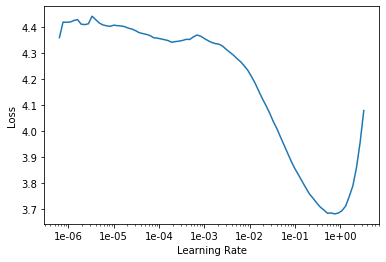

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(5, 1e-2) #moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.459599,2.235626,0.589201,00:09
1,2.688527,2.033048,0.617092,00:09
2,2.370883,1.997225,0.620238,00:09
3,2.179457,2.006406,0.619558,00:09
4,2.074407,2.000754,0.622619,00:09


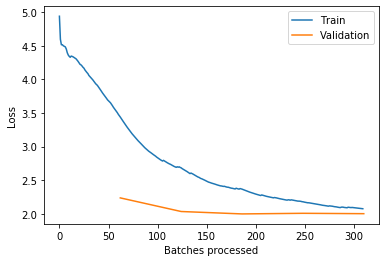

In [14]:
learn.recorder.plot_losses()

In [15]:
learn.save_encoder('enc_step1')

In [37]:
learn.load_encoder('enc_step1');

In [38]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.017645,1.998970,0.623129,00:09
1,2.014825,1.999364,0.622449,00:09
2,2.004549,2.001128,0.621343,00:09


In [39]:
learn.save_encoder('enc_step2')

In [40]:
learn.load_encoder('enc_step2');

In [41]:
learn.fit_one_cycle(7, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.038743,2.003179,0.620748,00:09
1,2.032196,2.010120,0.619133,00:09
2,2.010690,2.017499,0.620493,00:09
3,1.972786,2.027854,0.616327,00:09
4,1.942452,2.028314,0.620323,00:09
5,1.893002,2.025856,0.619218,00:09
6,1.857769,2.026636,0.620748,00:09


In [42]:
learn.save_encoder('enc_step3')

In [46]:
learn.load_encoder('enc_step3');

In [44]:
learn.fit_one_cycle(7, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.839201,2.025731,0.621514,00:09
1,1.869192,2.029004,0.621259,00:09
2,1.858738,2.030196,0.619728,00:09
3,1.840706,2.033986,0.619813,00:09
4,1.829709,2.031010,0.619133,00:09
5,1.855217,2.030528,0.619813,00:09
6,1.823092,2.030191,0.619728,00:09


In [60]:
learn.save_encoder('movie_encoder')

## Train category here

In [49]:
movies.head(3)

,movie_name,category_0
0,Caught Up (1998),Crime
1,Mrs. Parker and the Vicious Circle (1994),Drama
2,Frisk (1995),Drama


In [50]:
movies = movies.sample(frac=1, replace=False)

In [51]:
movies.head(3)

,movie_name,category_0
2334,Harvey (1950),Comedy
7529,"Matrix, The (1999)",Action
7024,Monster in the Closet (1986),Comedy


In [57]:
path = ''
bs=20#64
data_clas = TextClasDataBunch.from_df(path, movies[0:8000],
                                      movies[8000:-1],
                                      vocab=data_lm.train_ds.vocab,
                                      text_cols='movie_name',
                                      label_cols='category_0', bs=bs)

/home/ubuntu/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
IMAX, (no genres listed)
  if getattr(ds, 'warn', False): warn(ds.warn)


In [58]:
data_clas.save('data_clas.pkl')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [59]:
data_clas.show_batch()

text,target
xxbos xxmaj every xxmaj man for xxmaj himself and xxmaj god xxmaj against xxmaj all ( a.k.a . xxmaj the xxmaj enigma of xxmaj kaspar xxmaj hauser ) ( a.k.a . xxmaj the xxmaj mystery of xxmaj kaspar xxmaj hauser ) ( xxmaj xxunk für xxunk und xxmaj xxunk xxmaj xxunk xxmaj xxunk ) ( 1974 ),Crime
"xxbos xxmaj lost xxmaj honor of xxmaj katharina xxmaj blum , xxmaj the ( xxmaj die xxmaj xxunk xxmaj xxunk der xxmaj katharina xxmaj blum xxunk : xxmaj wie xxmaj xxunk xxunk und xxunk xxunk xxunk xxunk ) ( 1975 )",Drama
"xxbos xxmaj dragon xxmaj that xxmaj was n't ( xxmaj or xxmaj was xxmaj he ? ) , xxmaj the ( xxmaj xxunk je xxunk xxunk ik xxunk ) ( 1983 )",Animation
xxbos xxmaj crimson xxmaj rivers 2 : xxmaj angels of the xxmaj apocalypse ( xxmaj les xxmaj xxunk xxunk xxup xxunk xxmaj les anges de xxunk ) ( 2004 ),Action
"xxbos xxmaj good , the xxmaj bad and the xxmaj ugly , xxmaj the ( xxmaj xxunk , il xxunk , il xxunk , xxmaj il ) ( 1966 )",Action


### Load model you trained in the language model step

In [68]:
!ls data/models

enc_step1.pth  enc_step2.pth  enc_step3.pth  movie_encoder.pth	tmp.pth


In [62]:
!cp 

LICENSE    data_clas.pkl	     predict_movie_categories.ipynb
README.md  implicit_with_text.ipynb  produce_encodings.ipynb
data	   modelo_final.ipynb	     src


In [71]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, path="data")
#learn.load_encoder('fine_tuned_enc')
learn.load_encoder('movie_encoder');


In [72]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


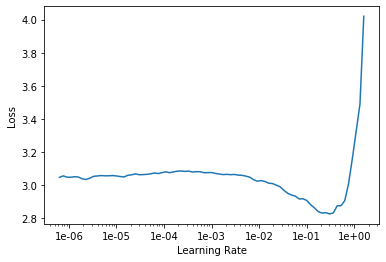

In [73]:
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(5, 1e-2),# moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.010123,1.926188,0.344287,00:11
1,1.953023,1.909081,0.334578,00:11
2,1.890339,1.872141,0.355863,00:11
3,1.875437,1.854811,0.353249,00:11
4,1.840554,1.841738,0.367812,00:11


(None,)

In [75]:
learn.save('cat_1')

In [77]:
learn.load('cat_1');

In [78]:
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
row_0,,,,,,,,,,,,,,,,,,
0,77,18,6,1,31,6,4,23,0,0,13,0,1,1,3,1,1,2
1,13,6,4,1,4,0,0,1,0,0,0,0,0,0,1,0,0,3
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,80,48,13,20,344,43,46,215,3,1,20,2,4,4,6,5,2,5
6,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
7,200,72,18,22,374,104,53,526,6,2,82,5,9,8,10,29,4,11
10,1,1,0,0,10,4,1,5,2,0,31,0,0,0,0,0,0,1


In [90]:
learn.predict('Exploding ships')

(Category Drama,
 tensor(7),
 tensor([0.0889, 0.0508, 0.0093, 0.0394, 0.2987, 0.0531, 0.0499, 0.3202, 0.0038,
         0.0050, 0.0296, 0.0087, 0.0038, 0.0073, 0.0074, 0.0087, 0.0016, 0.0138]))

In [100]:
learn.predict('Los venegas')

(Category Comedy,
 tensor(4),
 tensor([0.0983, 0.0224, 0.0056, 0.0324, 0.3285, 0.0643, 0.0422, 0.3149, 0.0026,
         0.0107, 0.0318, 0.0105, 0.0045, 0.0057, 0.0049, 0.0095, 0.0008, 0.0104]))

In [80]:
learn.predict('Two stupid dogs')

(Category Comedy,
 tensor(4),
 tensor([6.8725e-02, 1.6494e-02, 5.1081e-03, 3.6803e-02, 5.3321e-01, 3.5063e-02,
         8.9320e-03, 2.5298e-01, 4.0800e-04, 2.6501e-03, 1.5923e-02, 5.9266e-03,
         1.1871e-03, 3.0353e-03, 1.8166e-03, 3.9959e-03, 3.9979e-04, 7.3474e-03]))

In [79]:
learn.predict('Apocalypse')

(Category Drama,
 tensor(7),
 tensor([0.1185, 0.0738, 0.0100, 0.0323, 0.2499, 0.0588, 0.0521, 0.2751, 0.0058,
         0.0092, 0.0419, 0.0086, 0.0074, 0.0066, 0.0158, 0.0098, 0.0027, 0.0217]))

In [ ]:
learn.freeze_to(-1)
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.save('cat_3')

In [ ]:
learn.load('cat_3')

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

In [ ]:
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)